# Clustering

**Outline**

In this tutorial we learn how to cluster data into homogenuous groups. We inspect both supervised and unsupervised machine learning approaches.

We proceed as follows:

- generate datasets
- create clusters using hierarchical clustering
    - visualisation of results for different algorithm parameters
    - visualisation of decision tree
- create clusters using k-means clustering
- predict continuous target using k-nearest neighbor algorithm
    
Additional resources:

- https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
- https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py
- https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # plot styling

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_s_curve # data generation
from sklearn.datasets import make_blobs # data generation
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import train_test_split
import sklearn
import warnings

from itertools import cycle, islice

pd.set_option('mode.chained_assignment',None)

# Generate datasets

We generate three structured sets of points in two-dimensional plane:

- data_circles consists of several circles inside each of other
- data_moons consists of two moons
- data_blobs consists of several blobs

Finally, we also denote generate points in rectangle from uniform distribution. This dataset will represent unstructured data.

In [2]:
np.random.seed(18)
n_samples = 1500 # Number of points generated

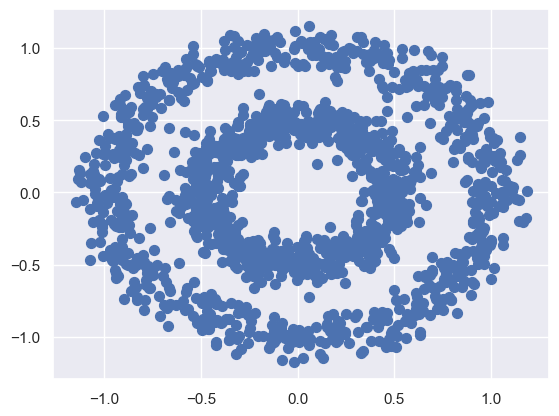

In [3]:
# Generate two circles, one within the other

data_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.08, random_state=18)
plt.scatter(data_circles[0][:, 0], data_circles[0][:, 1], s=50)

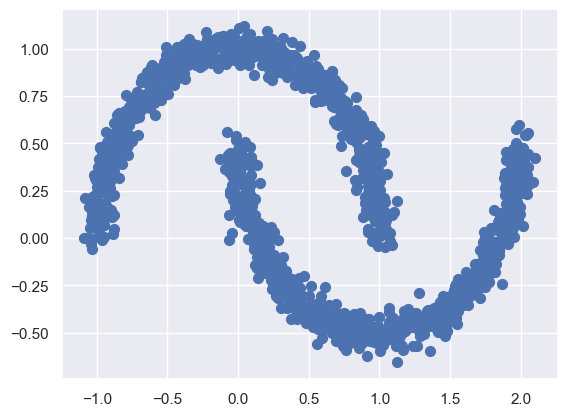

In [4]:
# Generate two moons

data_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=18)
plt.scatter(data_moons[0][:, 0], data_moons[0][:, 1], s=50)

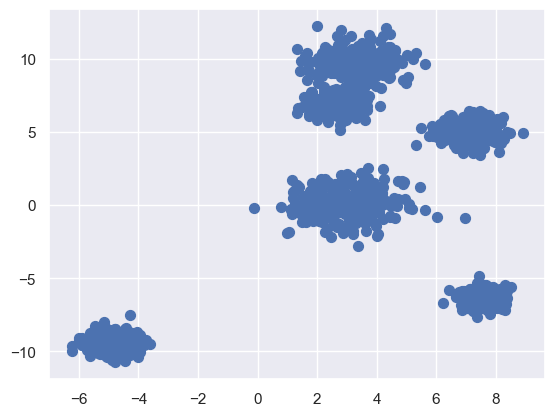

In [5]:
# Generate several bobs

data_blobs = datasets.make_blobs(n_samples=n_samples, centers=6, cluster_std=[1, 0.4, 0.6, 0.8, 0.5, 0.5], random_state=18)
plt.scatter(data_blobs[0][:, 0], data_blobs[0][:, 1], s=50)

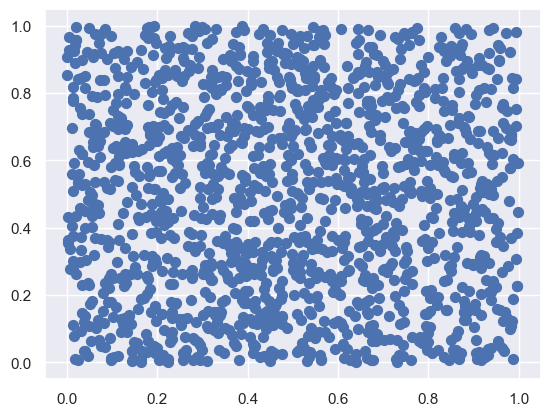

In [6]:
# Generate uniformly distributed points

data_random = np.random.rand(n_samples, 2), None
plt.scatter(data_random[0][:, 0], data_random[0][:, 1], s=50)

# Hierarchical clustering

We investigate hierarchical clustering as implemented in sklearn

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

It performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. In every step we find two clusters with the lowest measure of dissimilarity and merge them until either

- only 'n_cluster' clusters is produced,
- dissimilarity for the most similar clusters do not attain 'distance_threshold' parameter,

depending on the parameter chosen.

Dissimilarity is measured using one of the following distances

- “l1”, “euclidean”, “cosine”, or “precomputed”

with obvious meaning. Dissimilarity of two clusters is then computed based on distances among data points in one of the following ways:

- 'Complete' maximum distance between observations of pairs of clusters.
- 'Average' average of the distances between all observations of pairs of clusters.
- 'Single' minimum distance between observations of pairs of clusters.
- 'Ward': variance of data points within new cluster

Note that due to implementation limitations, several combinations of distance-aggregation method are not available.

## Linkage

We inspect influence of aggregation of distances (so called linkage).

In [7]:
# TODO: Adjust the following parameters and discuss the resulting clusters computed in the following cell.
n_cluster = 4 # Create 'n_cluster' clusters
distance_threshold = None # Create clusters until 'distance_threshold' is reached

# Important note: Exactly one of the above two parameters has to be set to 'None'

# TODO: Answer why for 'n_cluster'==4, 'linkage'=='single' the moons are separated, while for other linkages it is not.
# TODO: 'distance_threshold' is a paremeter whose optimal value depends on the dataset. Identify the function/method that we used to tackle this problem in the below cell.

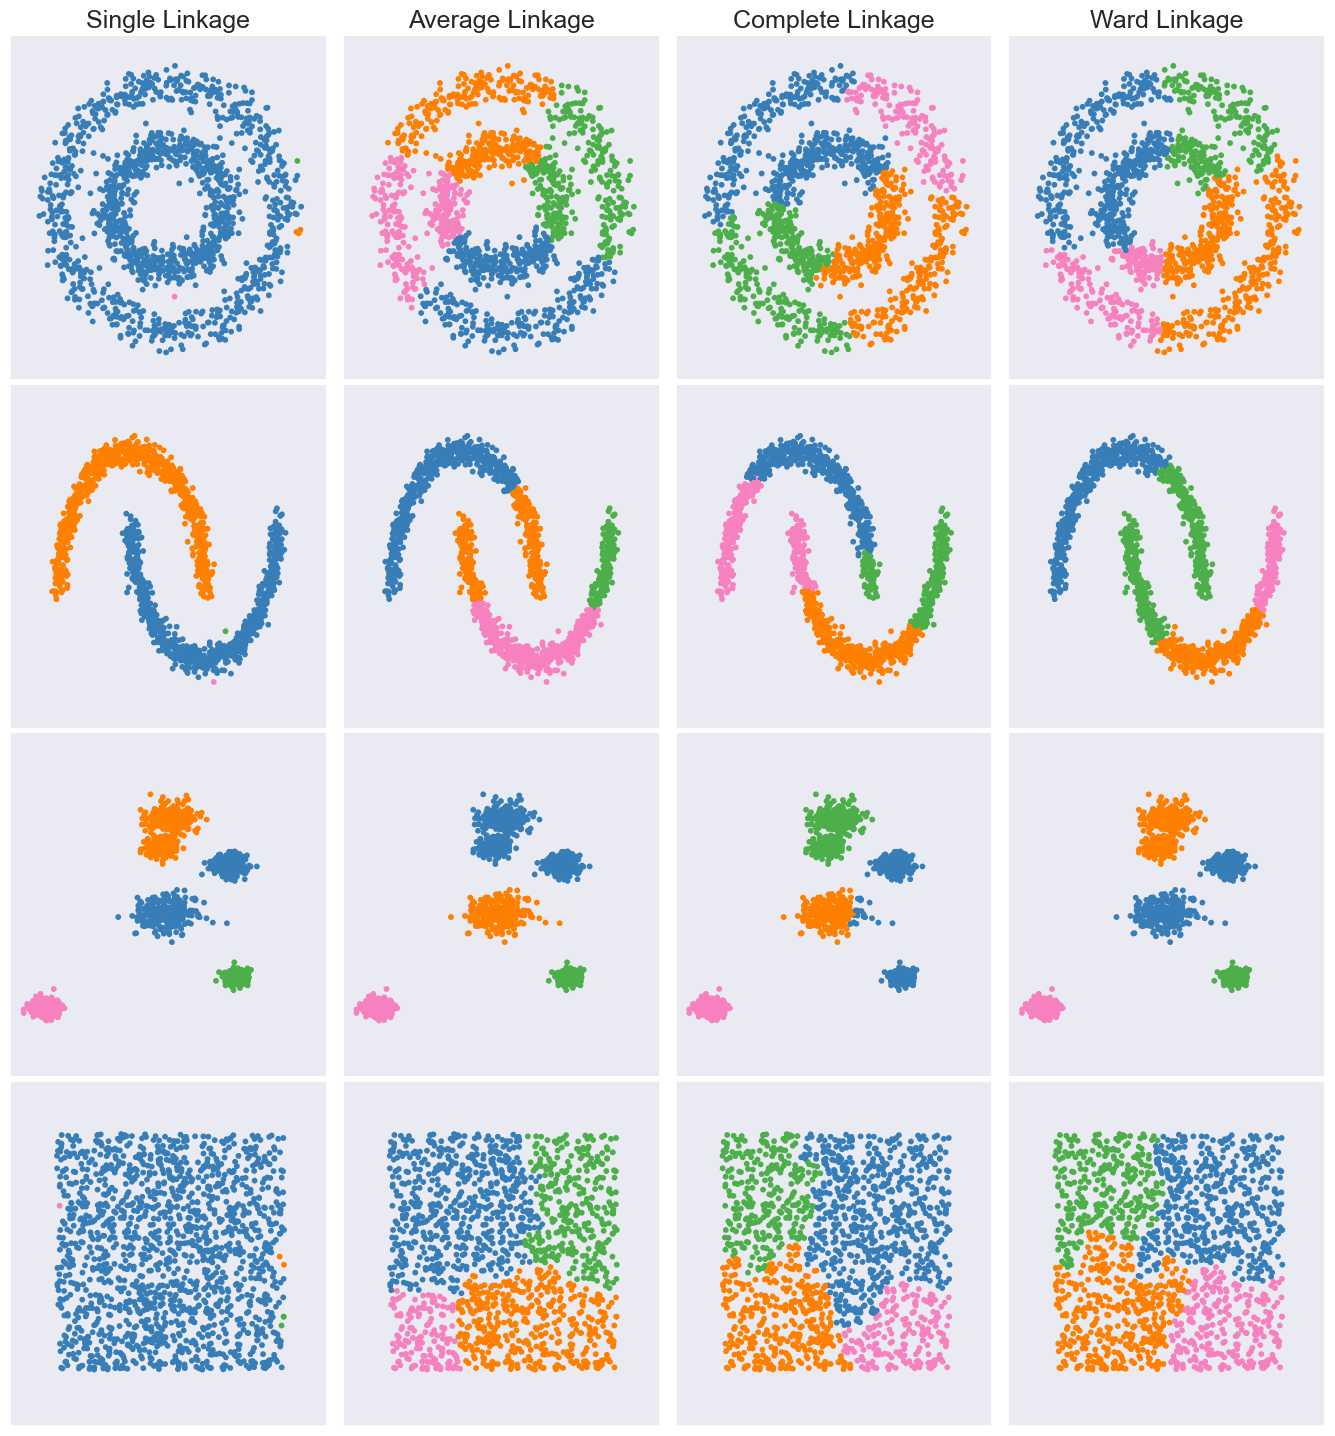

In [8]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

# Init test datasets
datasets = [data_circles, data_moons, data_blobs, data_random]

# Iterate over different algorithm settings
plot_num = 1
for i_dataset, dataset in enumerate(datasets):

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=n_cluster, linkage="ward", distance_threshold=distance_threshold
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=n_cluster, linkage="complete", distance_threshold=distance_threshold
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=n_cluster, linkage="average", distance_threshold=distance_threshold
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=n_cluster, linkage="single", distance_threshold=distance_threshold
    )

    clustering_algorithms = (
        ("Single Linkage", single),
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward),
    )

    for name, algorithm in clustering_algorithms:

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()

## Number of clusters

The parameter 'n_clusters' is essential as can if we visualise results for different values of this parameter.

In [9]:
# TODO: Adjust the following parameters and discuss influence on the results.
n_clusters = [
    3, 4, 5, 6
]
# Considered clusters counts (Note: for implementation reasons it should be len(n_clusters)==4)

# Considered linkage
linkage = "ward"

# Considered metric
metric = "euclidean"

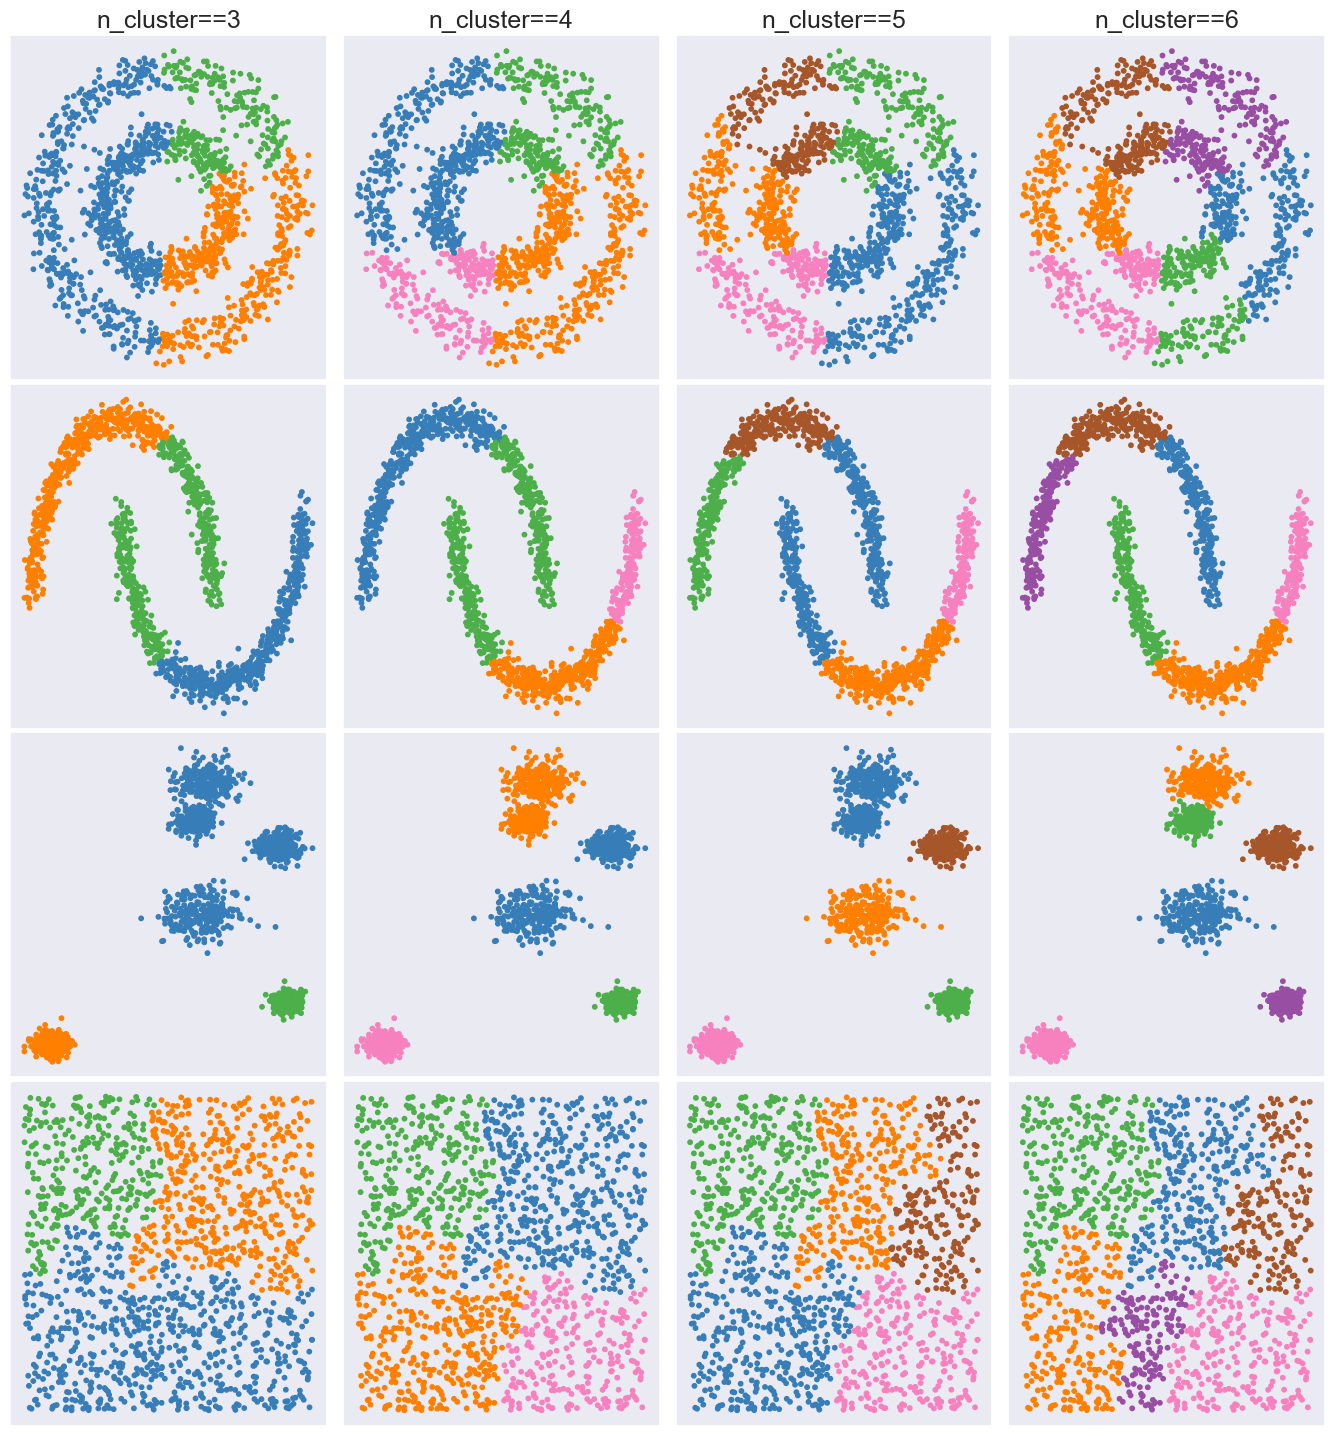

In [11]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

# Init test datasets
datasets = [data_circles, data_moons, data_blobs, data_random]


# Iterate over different algorithm settings
plot_num = 1
for i_dataset, dataset in enumerate(datasets):

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    for n_cluster in n_clusters:
        
        algorithm = cluster.AgglomerativeClustering(
            n_clusters=n_cluster, linkage=linkage, metric=metric
        )

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title("n_cluster==" + str(n_cluster), size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()

## Distances

We visualise results for different metrics.

In [12]:
# TODO: Adjust the following parameters and discuss influence on the results.
n_cluster = 3
linkage = "complete"
metrics = ["l1", "euclidean"] # Note: for linkage=="ward" only "euclidean" is accepted

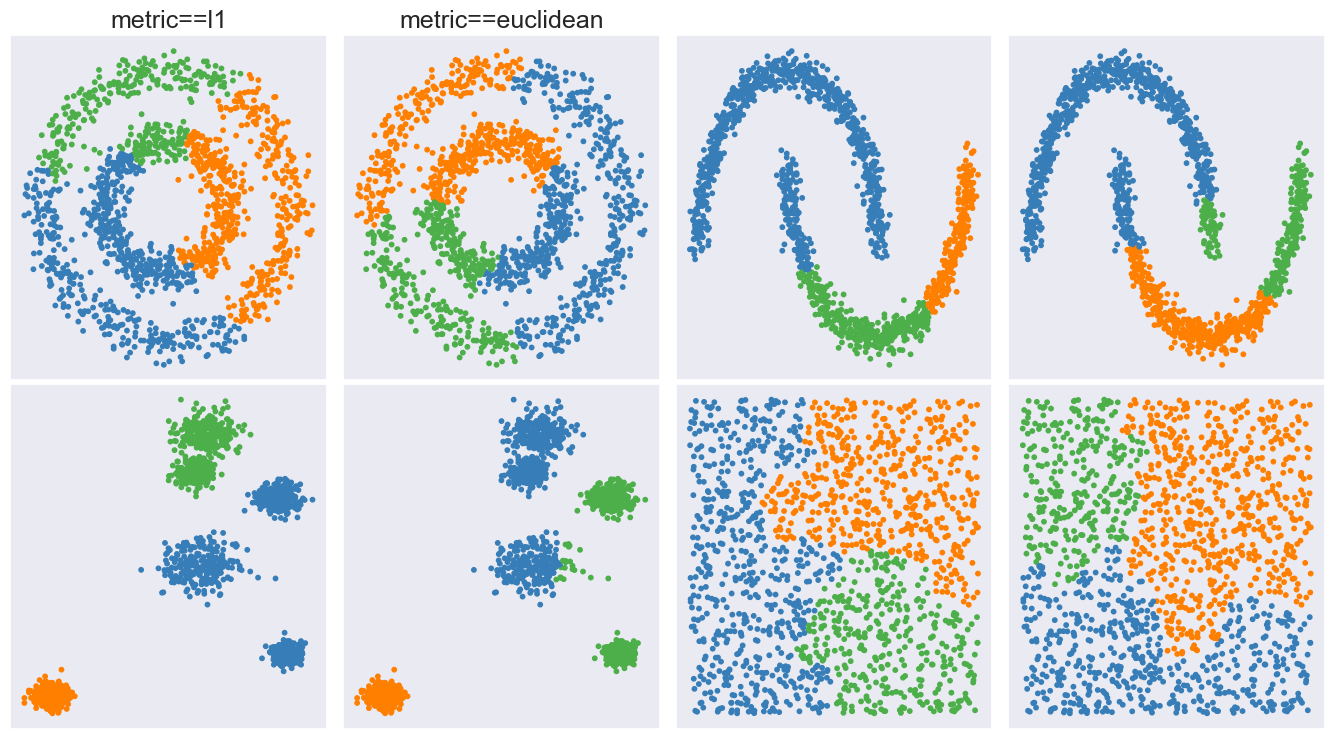

In [13]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)


# Init test datasets
datasets = [
    data_circles, data_moons, data_blobs, data_random
]


# Iterate over different algorithm settings
plot_num = 1
for i_dataset, dataset in enumerate(datasets):

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    for metric in metrics:
        
        algorithm = cluster.AgglomerativeClustering(
            n_clusters=n_cluster, linkage=linkage, metric=metric
        )

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title("metric==" + metric, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        plt.xticks(())
        plt.yticks(())

        plot_num += 1

plt.show()

## Dendrogram

A tree-like structure that fully represents the hierarchical model.

Every leaf represents single data point and every node represents cluster that contains all data points in its subtree.

In [14]:
def plot_dendrogram(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, truncate_mode="level", p=3)

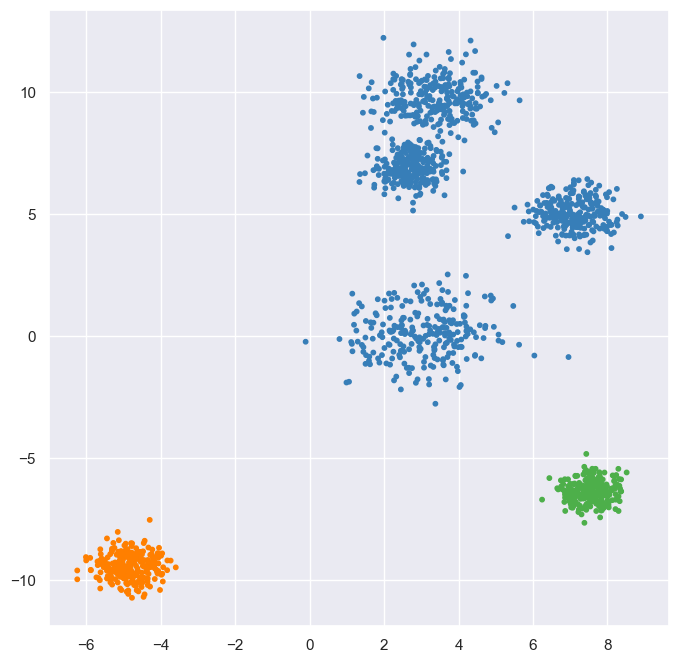

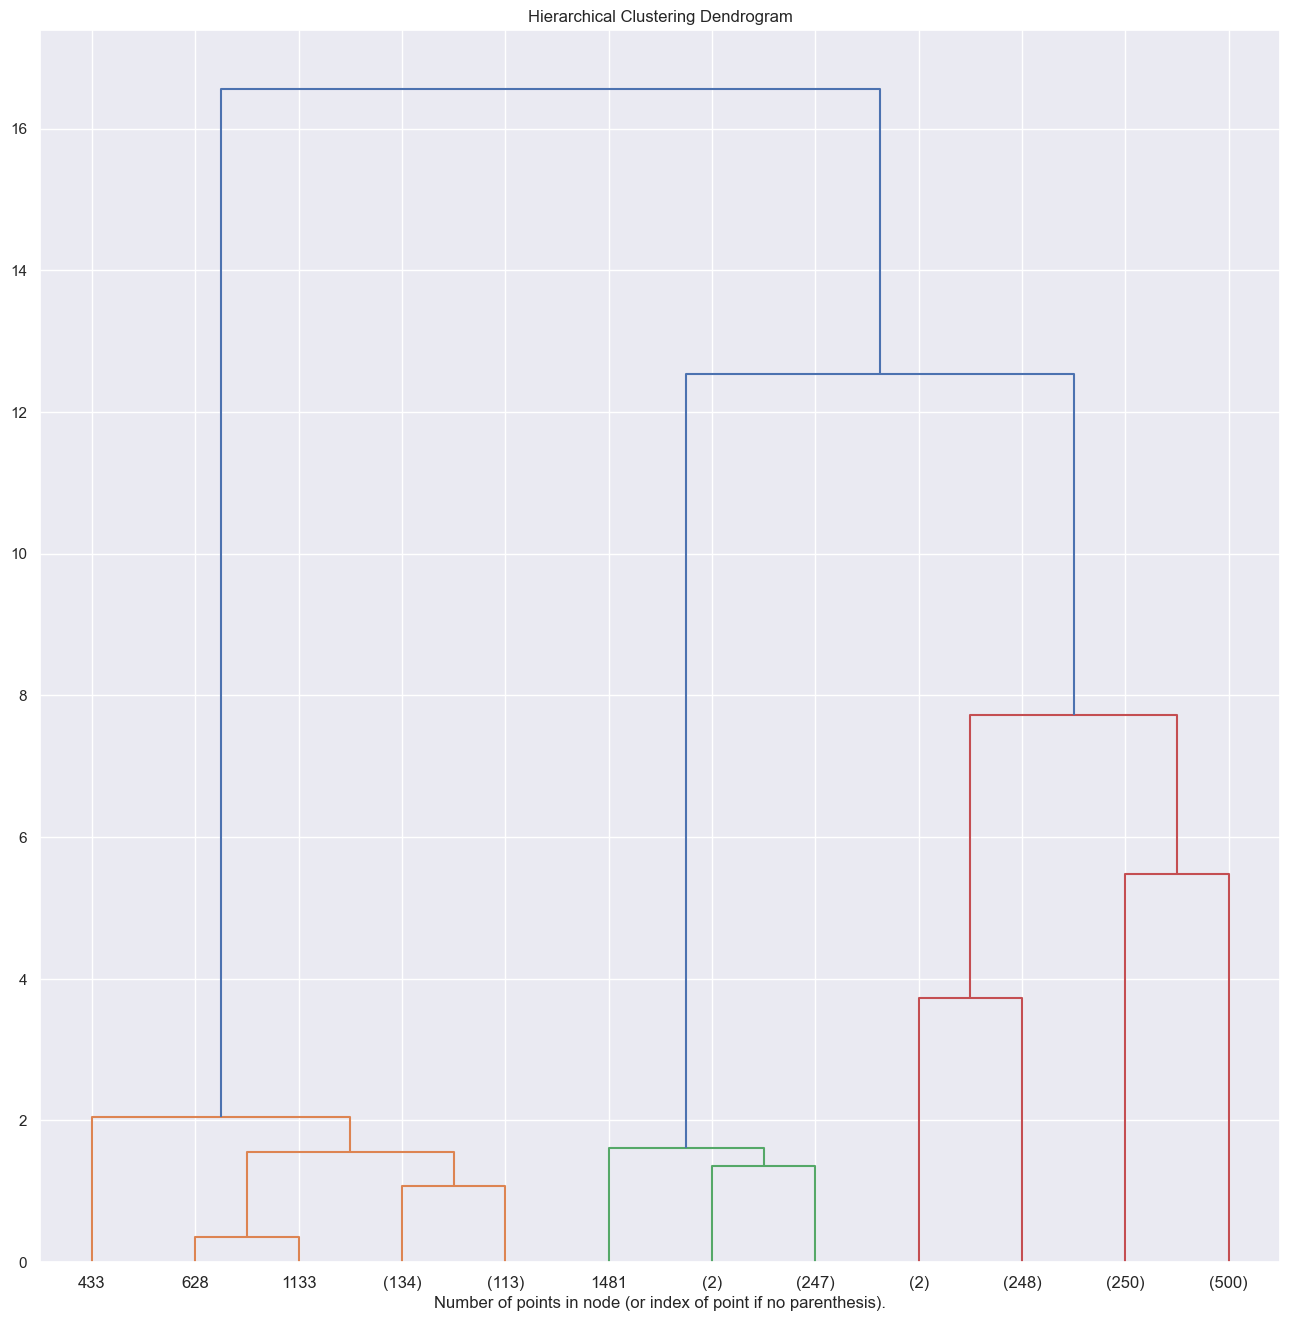

In [15]:
# TODO: Adjust parameters 'n–clusters' or 'distance_threshold' and comparing the results, explain produced dendrogram.

distance_threshold=10
n_clusters=None
# Note: exactly one of 'distance_threshold', 'n_clusters' has to be set to 'None'

# Fit
X, y = data_blobs
model = cluster.AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters, linkage="average", compute_distances=True)
model = model.fit(X)

plt.figure(figsize=(8, 8))
y_pred = model.labels_.astype(int)

colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )

plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
plt.show()

# Plot
plt.figure(figsize=(16, 16))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Hierarchical clustering in seaborn

In [68]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=20, 
    n_features=15, 
    n_informative=2, 
    n_redundant=5, 
    n_repeated=2,
    n_classes=2,
    flip_y=0.1,
    random_state=42
)

X = pd.DataFrame(X)

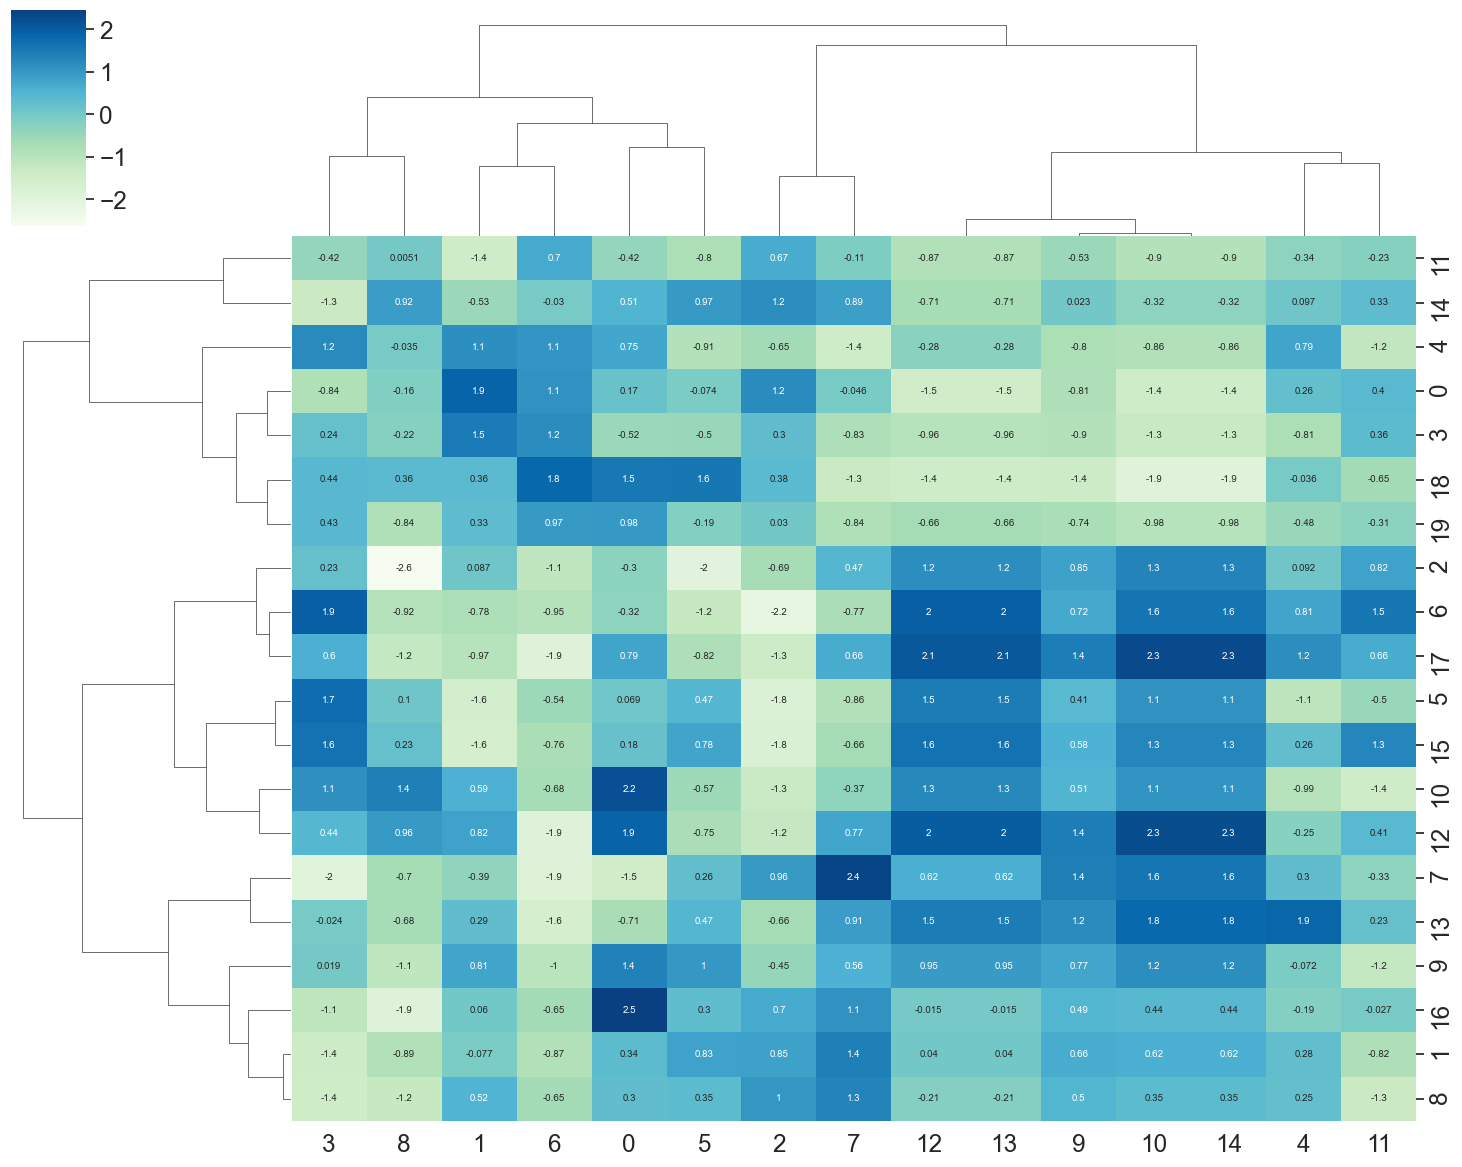

In [69]:
import seaborn as sns

sns.set(font_scale=1.6)
sns.clustermap(X, method="complete", metric="correlation", annot=True, cmap='GnBu',
               annot_kws={"size": 7}, figsize=(15,12));

sns.set(font_scale=1.0)

# K-means

Unsupervised clustering algorithm.

Starts with initialized centroids and using specified distance run iterations as follows:

- assign the nearest centroid for every data point
- adjust centroids so that they represent 'their' data points.

Either number of iterations or some distance threshold is given as a stopping criterion. Many variants of this algorithm exist as distance or adjustment method may vary. In the sequel we provide implementation and visualisation of our own of this simple algorithm

Note that after unsupervised training, one can use the trained centroids for future prediction of unseen data points in the obvious way.

### Functions

In [18]:
def get_centroid(centroids, x, y):
    
    """
        Return index of nearest centroid to given point
        
        Args:
            - centroids: list of centroids represented by tuples
            - x: first component of a given point
            - y: second component of a given point
            
        Returns:
            int: index of the nearest centroid from the list 'centroids'
    """
    
    i_min = -1
    dist_min = np.inf
    for i, centroid in enumerate(centroids):
    
        dist = (abs(centroid[0]-x))**2+(abs(centroid[1]-y))**2
        
        if dist < dist_min:
            i_min = i
            dist_min = dist
            
    if i_min == -1:
        print('Unexpected result.')
    else:
        return i_min
    
def init_centroid(data, k_cluster):
    
    """
        Returns list of centroids as initialization for k-means algorithm.
        Centroids are generated from uniform distribution in the observation window.
    
        Args:
            - data: dataset considered for k-means, dataframe that contains columns 'x', 'y'
            - k_cluster: number of centroids to be generated
    
        Returns:
            list: list of tuples representing generated centroids
    """
    
    x_max, y_max = data['x'].max(), data['y'].max()
    x_min, y_min = data['x'].min(), data['y'].min()

    centroids = [
        (np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)) for i in range(k_cluster)
    ]
    
    return centroids

### Parameters

In [19]:
data_kmeans = pd.DataFrame({'x': data_blobs[0][:, 0], 'y': data_blobs[0][:, 1]}) # Considered data
k_cluster = 5 # Number of clusters
i_iter = 4 # Number of iterations
np.random.seed(21)

### Initialization

In [20]:
centroids = init_centroid(data_kmeans, k_cluster)

### Algorithm

We visualise every iteration of the algorithm. Two phases in every iteration:

- find the nearest neighbor
- adjust centroids

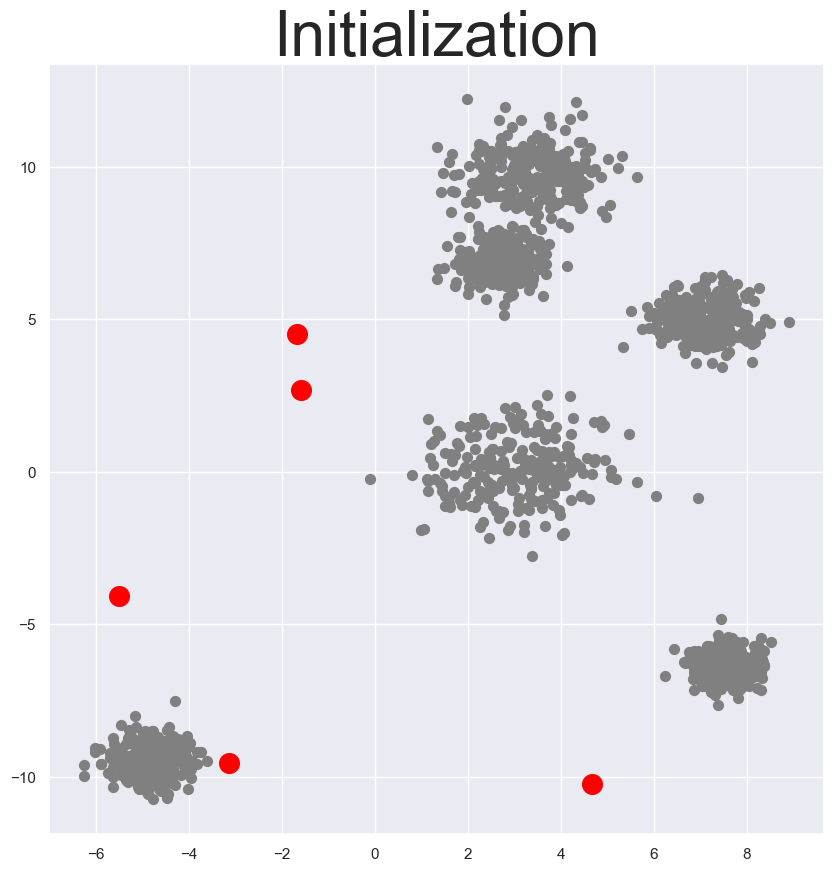

KeyError: 'centroid'

<Figure size 1000x1000 with 0 Axes>

In [21]:
# TODO: Complete all necessary steps in the following loop.

# Plot init
plt.figure(figsize=(10, 10))
plt.scatter(data_kmeans['x'], data_kmeans['y'], c='grey', s=50)
plt.scatter([a[0] for a in centroids], [a[1] for a in centroids], c='red', s=200)
plt.title("Initialization", fontsize=45)
plt.show()

for i in range(i_iter):
    
    # TODO: use 'get_centroid' to store the nearest centroid for every point in 'data_kmens' as a column 'centroid'
    ...
    
    # Plot the 'find the nearest neighbor' phase
    plt.figure(figsize=(10, 10))
    plt.scatter(data_kmeans['x'], data_kmeans['y'], c=data_kmeans['centroid'], s=50, cmap='viridis')
    plt.scatter([a[0] for a in centroids], [a[1] for a in centroids], c='red', s=200)
    plt.title("Iteration " + str(i+1) + ": find centroids", fontsize=45)
    plt.show()
    
    # TODO: Compute new centroids (store as dataframe 'centroids' with columns 'x', 'y')
    ...
    
    # Plot the 'adjust centroids' phase
    plt.figure(figsize=(10, 10))
    plt.scatter(data_kmeans['x'], data_kmeans['y'], c=data_kmeans['centroid'], s=50, cmap='viridis')
    plt.scatter(centroids['x'], centroids['y'], c='red', s=200, alpha=0.9)
    plt.title("Iteration " + str(i+1) + ": adjust centroids", fontsize=45)
    plt.show()
    
    # Save centroids as list
    centroids = centroids.values.tolist()

In [ ]:
# TODO: Consider different aggregation techniques in the above loop for computing centroids and discuss their behavior
# TODO: For 'k_cluster'==5, 'i_iter'==4, np.random.seed(21) we obtain only 4 clusters. Discuss why.
# TODO: Adjust 'get_centroid' so that different metric is considered and observe possible changes.

### Outliers

We add data point far away from our original dataset and observe changes in the clustering.

In [ ]:
## K-means outliers
data_kmeans = pd.DataFrame({'x': data_blobs[0][:, 0], 'y': data_blobs[0][:, 1]})
data_kmeans = data_kmeans.append({'x': data_kmeans['x'].max()*3, 'y':data_kmeans['y'].max()*3}, ignore_index=True)

k_cluster = 5 # number of centroids
i_iter = 4
np.random.seed(21)
centroids = init_centroid(data_kmeans, k_cluster)

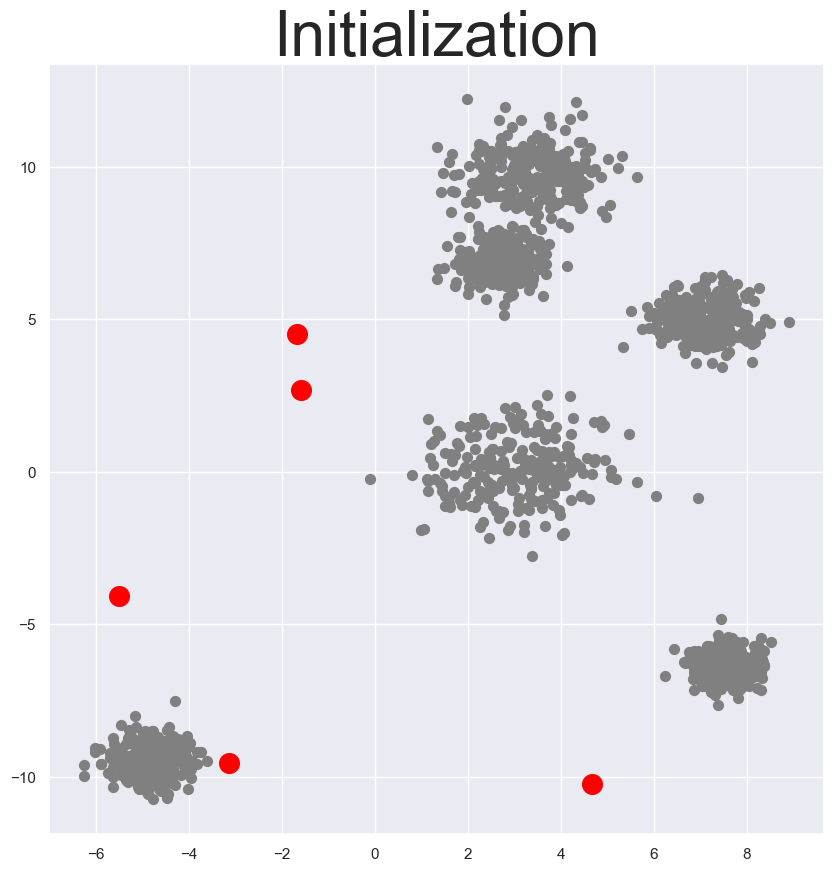

5


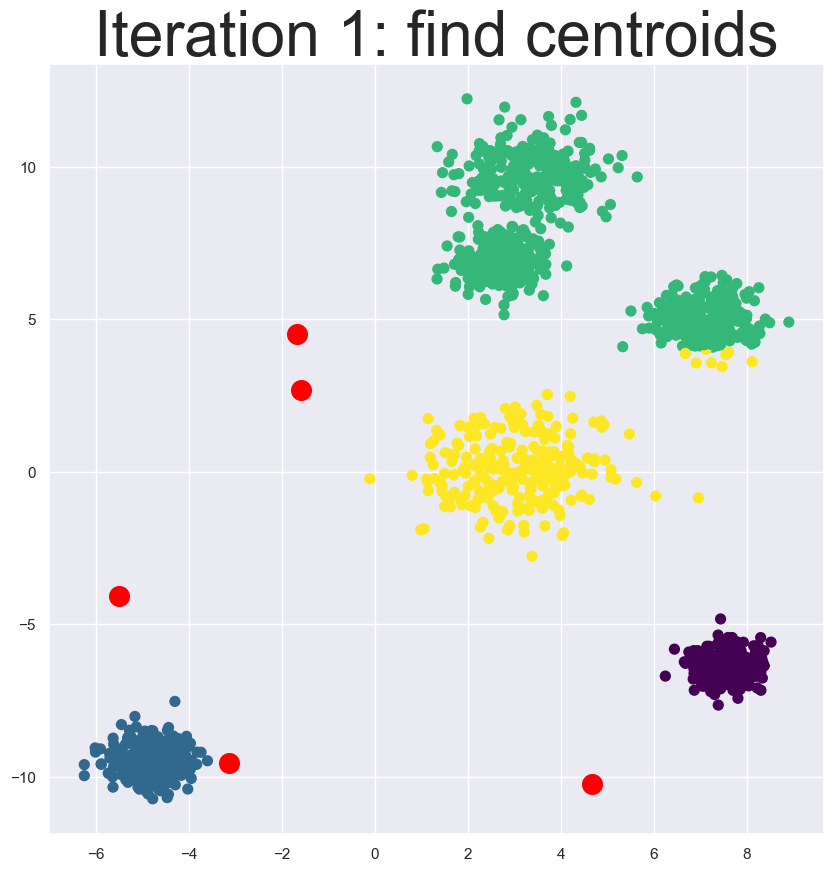

C:\Users\tyblondr\AppData\Local\Temp\ipykernel_11448\3619527299.py:25: FutureWarning: The provided callable <function mean at 0x000002A2DE0EC4C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  centroids = data_kmeans.groupby('centroid').agg(


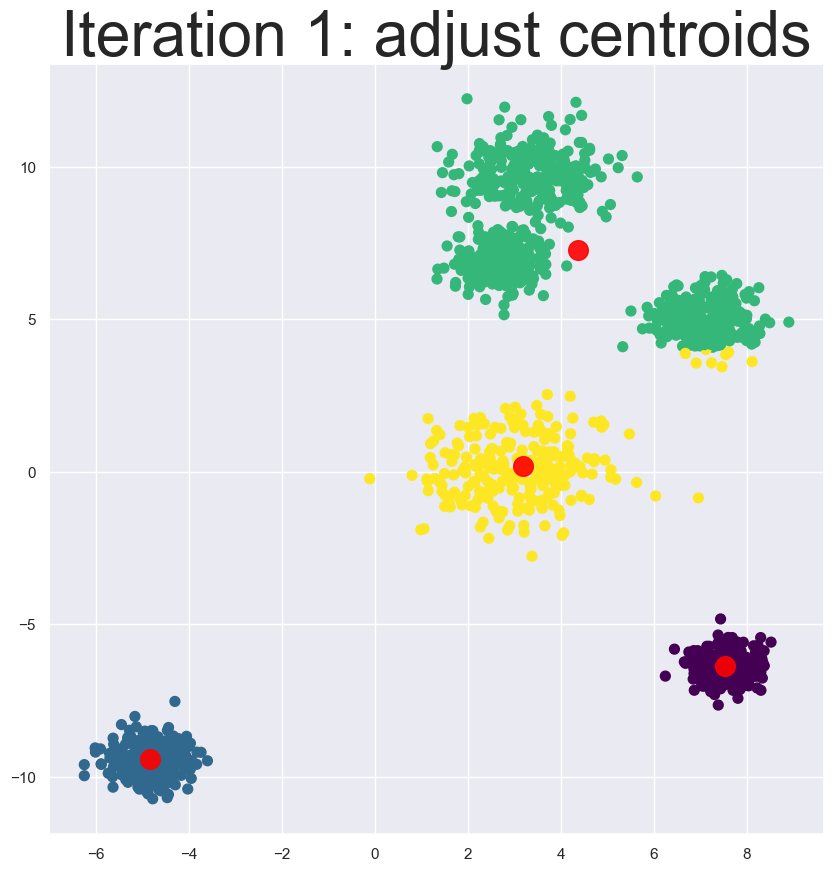

4


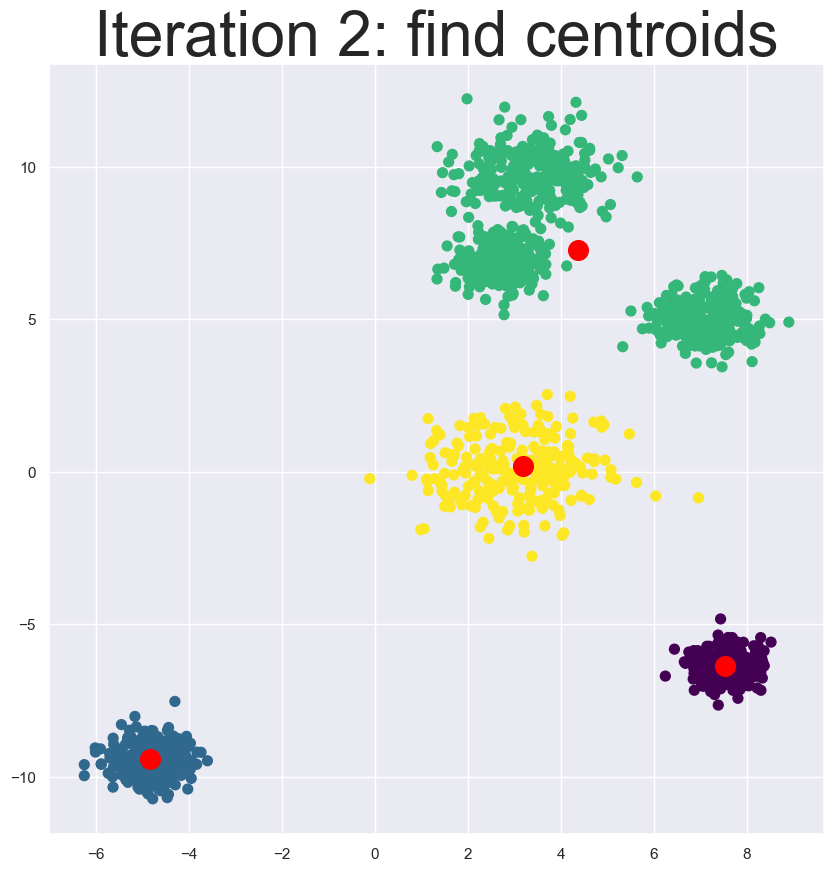

C:\Users\tyblondr\AppData\Local\Temp\ipykernel_11448\3619527299.py:25: FutureWarning: The provided callable <function mean at 0x000002A2DE0EC4C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  centroids = data_kmeans.groupby('centroid').agg(


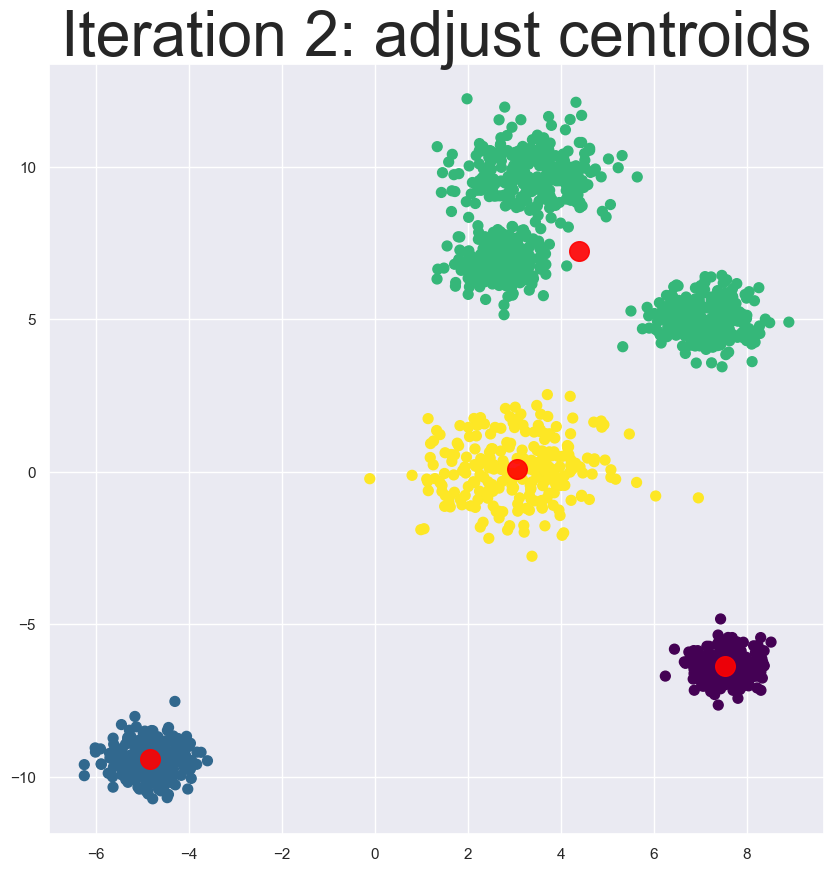

4


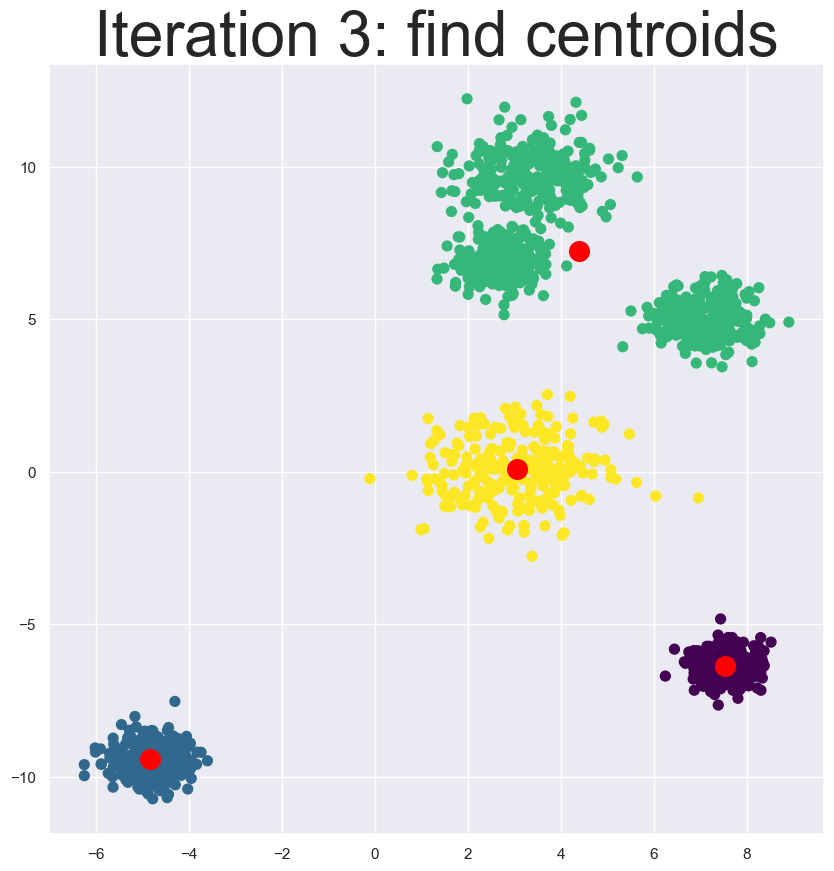

C:\Users\tyblondr\AppData\Local\Temp\ipykernel_11448\3619527299.py:25: FutureWarning: The provided callable <function mean at 0x000002A2DE0EC4C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  centroids = data_kmeans.groupby('centroid').agg(


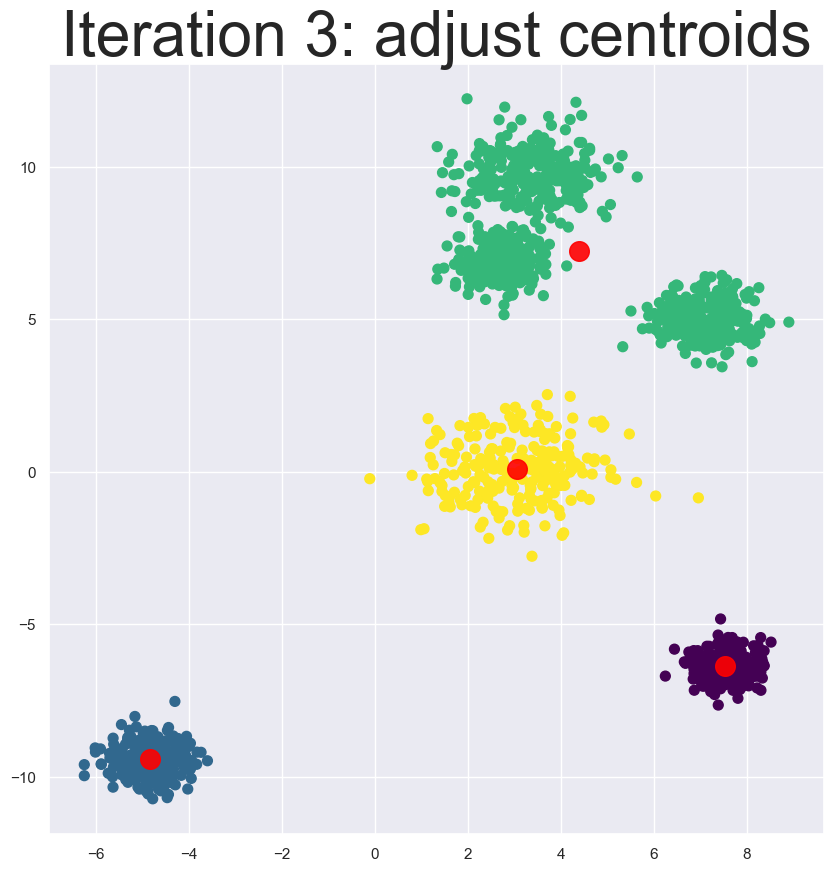

4


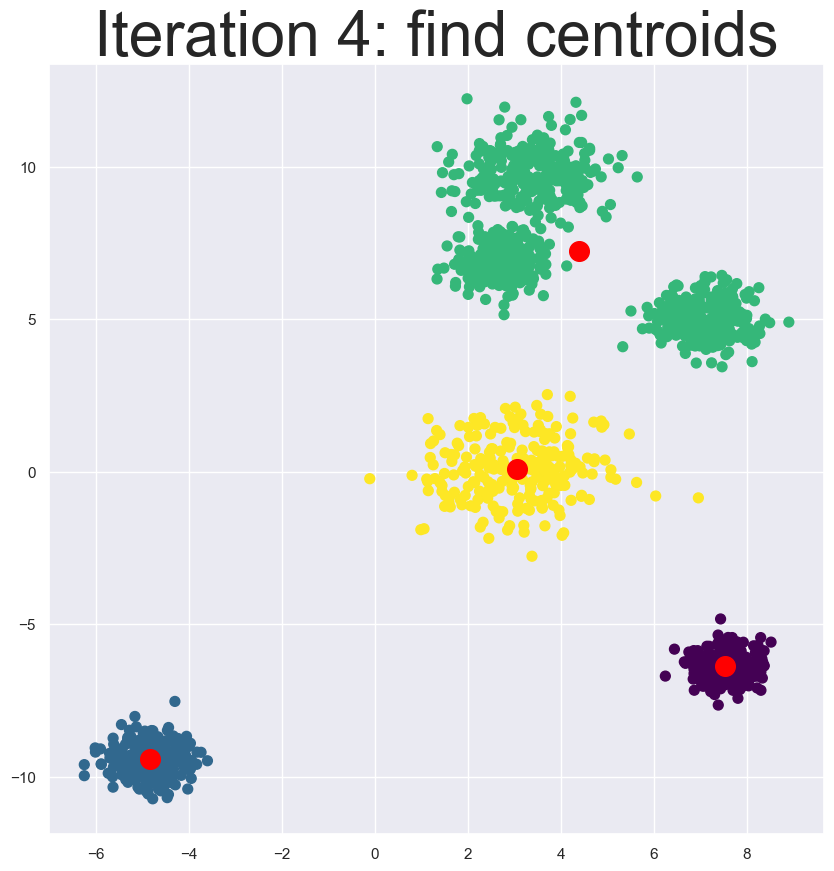

C:\Users\tyblondr\AppData\Local\Temp\ipykernel_11448\3619527299.py:25: FutureWarning: The provided callable <function mean at 0x000002A2DE0EC4C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  centroids = data_kmeans.groupby('centroid').agg(


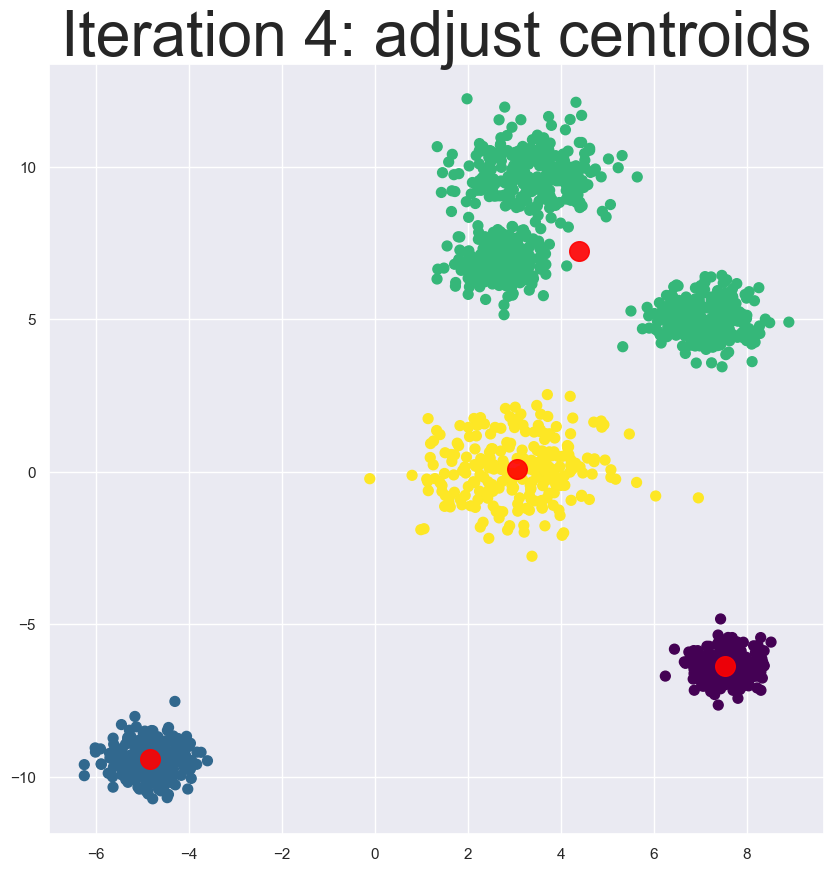

In [22]:
# Cluster the same datasets as above, write loop manually, visualise every iteration

# Plot init
plt.figure(figsize=(10, 10))
plt.scatter(data_kmeans['x'], data_kmeans['y'], c='grey', s=50)
plt.scatter([a[0] for a in centroids], [a[1] for a in centroids], c='red', s=200)
plt.title("Initialization", fontsize=45)
plt.show()

for i in range(i_iter):
    
    print(len(centroids))
    
    # Compute nearest centroid
    data_kmeans['centroid'] = data_kmeans.apply(lambda u: get_centroid(centroids, u['x'], u['y']), axis=1)
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(data_kmeans['x'], data_kmeans['y'], c=data_kmeans['centroid'], s=50, cmap='viridis')
    plt.scatter([a[0] for a in centroids], [a[1] for a in centroids], c='red', s=200)
    plt.title("Iteration " + str(i+1) + ": find centroids", fontsize=45)
    plt.show()
    
    # Adjust centroids
    centroids = data_kmeans.groupby('centroid').agg(
        x=('x', np.mean),
        y=('y', np.mean),
    )
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(data_kmeans['x'], data_kmeans['y'], c=data_kmeans['centroid'], s=50, cmap='viridis')
    plt.scatter(centroids['x'], centroids['y'], c='red', s=200, alpha=0.9)
    plt.title("Iteration " + str(i+1) + ": adjust centroids", fontsize=45)
    plt.show()
    
    # Save centroids as list
    centroids = centroids.values.tolist()

In [23]:
# After initialization using uniform distribution there is high probability that we lost some clusters and/or
# the outliers are assigned their own cluster.

# TODO: Adjust the method 'init_centroid' so that probability that outlier creates their own cluster is low. Observe changes in the algorithm
def init_centroid(data, k_cluster):
    
    ...
    
    return centroids

centroids = init_centroid(data_kmeans, k_cluster)

# K-nearest neighbors

We inspect prediction algorithm that utilizes the distances between predictors. Namely, given labeled data points and an unlabeled data point, we predict the label using labels of its neighbors. Either fixed number of neighbors is considered or all neighbors within given distance; then some aggregation technique is used to compute the prediction.

In our case we predict 0/1-valued TARGET from credit risk dataset.

### Import data & manipulate data

In [27]:
from pathlib import Path
data_file = Path("../Data/data_devsample.csv")

In [28]:
data = pd.read_csv(data_file, sep = ',', encoding = 'utf-8', low_memory=False, index_col='SK_ID_CURR')
print(f'data is object of type:   {type(data)}')
print(f'Number of rows:      {data.shape[0]}')
print(f'Number of columns:   {data.shape[1]}')

data is object of type:   <class 'pandas.core.frame.DataFrame'>
Number of rows:      80000
Number of columns:   196


In [29]:
data = data[['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OCCUPATION_TYPE']]
data = data.head(1000)

In [30]:
# We separate continuous and categorical predictors
preds_cont = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
preds_cat = ['OCCUPATION_TYPE']

The dataset contains continuous and categorical predictors. Therefore, a suitable distance has to be introduced. We measure the distance of vectors $x, y$ as

\begin{align*}
dist(x, y)=\sum_{k\in Cont}{(x_k-y_k)^2}+\gamma\sum_{l\in Cat}{(1-\delta_{x_l, y_l})},
\end{align*}
for some metaparameter $\gamma\geq 0$, where $Cont$ denotes the set of indices containing continuous variables, $Cat$ similarly for categorial ones, $\delta$ is the delta function.

In [31]:
# Drop rows with missing target
data = data[data['TARGET'].notna()]

# Fill missing values for continuous variables
data.fillna((data[preds_cont].mean()), inplace=True)

# Fill missing values for categorical variable by placeholder 'MISSING_VALUE'
data.fillna('MISSING_VALUE', inplace=True)

data.head(10)

TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                      
215138         0.0          135000.0    646920.0      25195.5   
325963         0.0          135000.0    740218.5      40284.0   
206923         0.0          180000.0    339241.5      12919.5   
265855         0.0          180000.0   1264428.0      37098.0   
359795         0.0           76500.0    202500.0      10125.0   
395230         0.0          180000.0    324216.0      25614.0   
230166         0.0          315000.0   1178703.0      79218.0   
286568         0.0          121500.0    188460.0      11515.5   
236576         0.0          144000.0    112068.0      12199.5   
204357         0.0           76500.0    270000.0      13500.0   

            AMT_GOODS_PRICE OCCUPATION_TYPE  
SK_ID_CURR                                   
215138             540000.0        Laborers  
325963             639000.0   MISSING_VALUE  
206923             238500.0        Laborers  
265855             990000.0        Laborers  
359795             202500.0   MISSING_VALUE  
395230             256500.0  Medicine staff  
230166            1129500.0         Drivers  
286568             135000.0     Sales staff  
236576              99000.0   MISSING_VALUE  
204357             270000.0        Laborers

In [32]:
# We have to standardize the continuous variables so that distances are comparable among different predictors.
data[preds_cont] = StandardScaler().fit_transform(data[preds_cont])

In [33]:
# Divide into train and test
data_train, data_test = train_test_split(data, test_size=0.1, random_state=17, stratify=data['TARGET'])

### Functions

In [34]:
def compute_dist(a, b, gamma=1):
    
    """
        Computes distance of two data points possibly containing categorical dimensions.
        
        Args:
            - a, b: data points as Series containing dimensions in lists preds_cont and preds_cat
            - gamma: parameter that specify distance (see above)
            
        Returns:
            float: distance of a,b
    
    """
    
    # Continuous dimensions
    dist_cont = 0
    for pred in preds_cont:
        dist_cont = dist_cont + (a[pred]-b[pred])**2
    
    # Categorical dimensions
    dist_cat = 0
    for pred in preds_cat:
        dist_cat += 1-int(a[pred]!=b[pred])
    
    return dist_cont + gamma*dist_cat

def predict(data, observation, gamma=1, k=50):
    
    """
        Computes prediction for one observation given labeled data and criterion how to determine neighborhood.
        
        Args:
            - data: labeled data containing dimensions in lists preds_cont and preds_cat
            - observation: unlabeled data point as Series containing dimensions in lists preds_cont and preds_cat
            - gamma: parameter specifying distance
            - k: number of neighbors to consider
    """
    
    # Compute distance to every data point from train data
    data['DIST'] = data.apply(lambda x: compute_dist(x, observation, gamma), axis=1)
    
    # Take 'k' closest neighbors
    data_neigh = data.sort_values('DIST',ascending = True).head(k)
    
    # Predict using neighbors
    return data_neigh['TARGET'].mean()
    

### Predict using k-nearest observations

Now we predict for test data for different values of 'k' and compare performance in terms of AUC.

Warning: Takes time even for k=30.

In [35]:
auc = {}
for k in range(1, 29, 2):

    data_test['PREDICTION'] = data_test.apply(lambda x: predict(data_train, x, 2, k), axis=1)
    auc[k] =  sklearn.metrics.roc_auc_score(data_test['TARGET'], data_test['PREDICTION'])

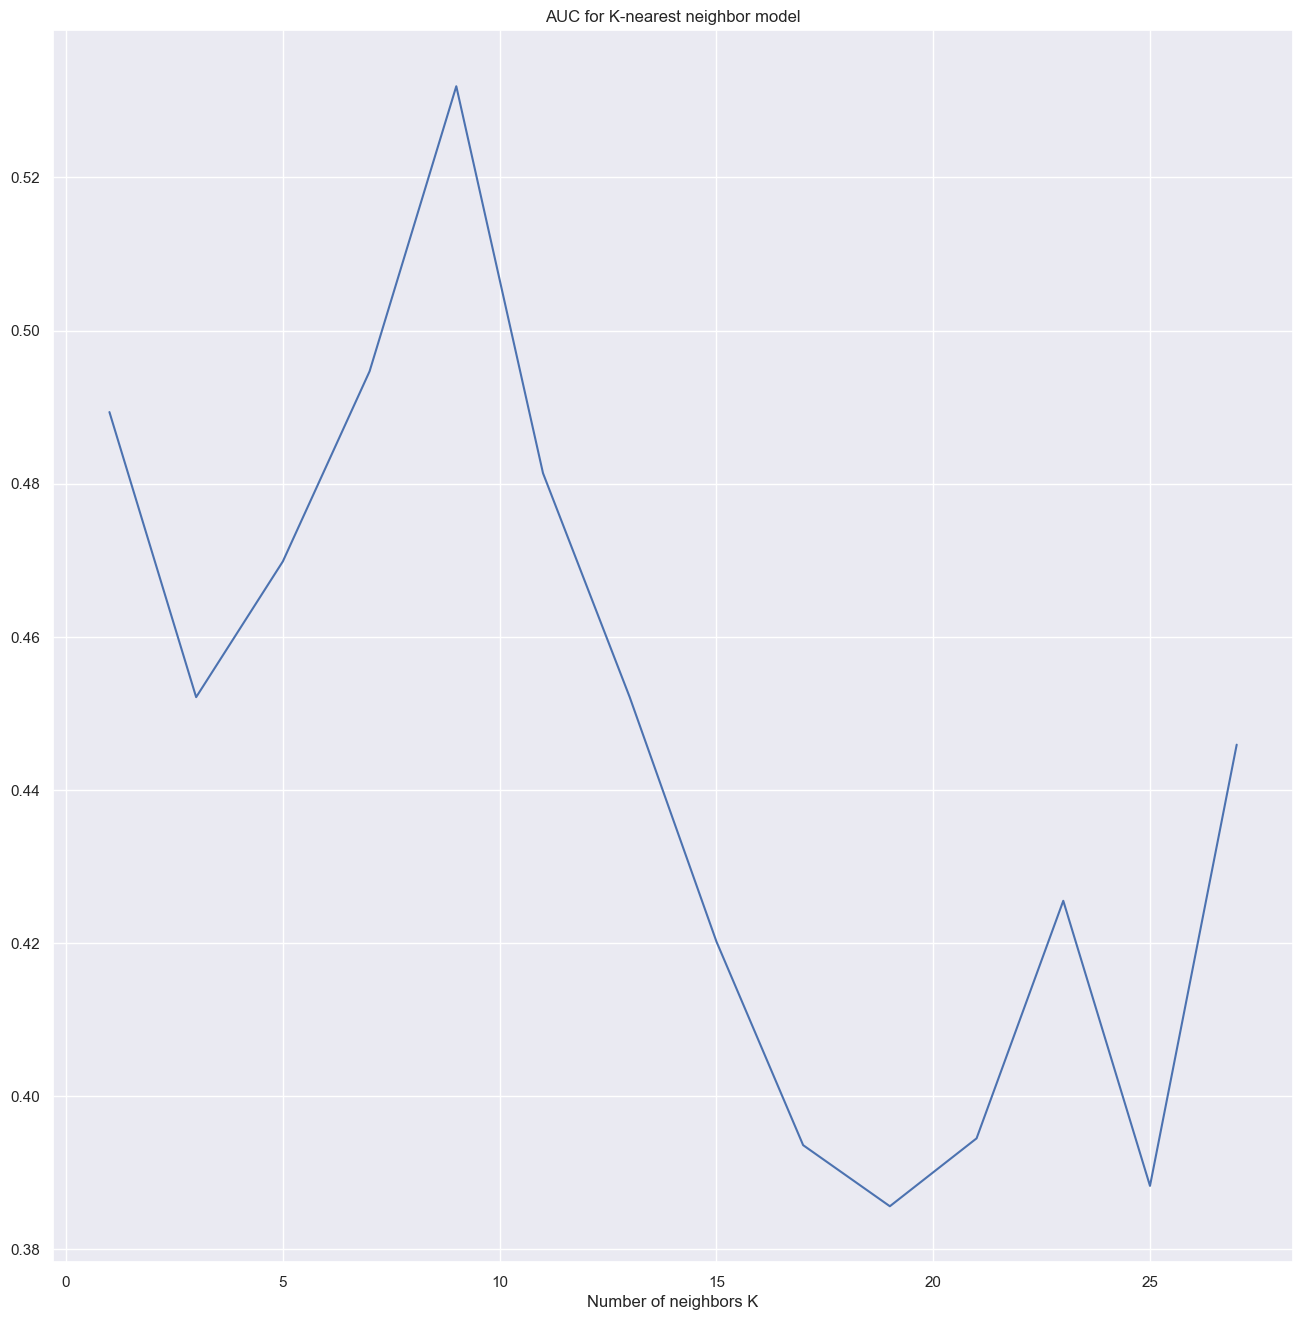

In [36]:
plt.figure(figsize=(16, 16))
plt.plot(*zip(*auc.items()))
plt.title('AUC for K-nearest neighbor model')
plt.xlabel('Number of neighbors K')
plt.show()

In [ ]:
# TODO: Adjust the function 'predict' so that parameter 'k' now stands for the radius that determines the neighborhood of given data point.